# Example: Circadian rhythm

A version of this notebook may be run online via Google Colab at https://tinyurl.com/rxd-circadian (make a copy or open in playground mode).

In [1]:
import neuron

Here we develop a NEURON implementation of the Leloup-Goldbeter model for circadian rhythms in Drosophila, using the version of the model specified in:

Leloup, J. C., Gonze, D., & Goldbeter, A. (1999). Limit cycle models for
circadian rhythms based on transcriptional regulation in Drosophila and
Neurospora. Journal of biological rhythms, 14(6), 433-448.
https://doi.org/10.1177/074873099129000948

We'll use the initial conditions from the BioModels version:
https://www.ebi.ac.uk/biomodels/BIOMD0000000298

## Load libraries

As usual, we'll want NEURON's h library and its standard run system as well as rxd. 

In [2]:
from neuron import h, rxd

h.load_file("stdrun.hoc")

1.0

We'll also use <tt>matplotlib</tt> to plot concentrations of circadian proteins over time. We could of course use NEURON's graphics, bokeh, or any other plotting library.

In [3]:
import matplotlib.pyplot as plt

## Units

Recall NEURON measures concentrations in mM and time in ms. Leloup et al., 1999, however expresses concentration in nM and time in hours. We could ignore the unit inconsistency and NEURON would still be able to run the simulation, however if we did so, this could cause problems for interacting with other NEURON mechanisms. To avoid this problem, we use the `nM` and `hour` units from `neuron.units` in addition to our usual `mV` for initializing the membrane potential:

In [4]:
from neuron.units import nM, hour, mV

## Helper functions for clarity

For clarity, we prefer to define parameters and species by just specifying their names and values instead of repeteadly writing <tt>rxd.Parameter</tt> or <tt>rxd.Species</tt>. Fortunately, since Python uses keyword arguments and allows functions to modify the global variable dictionary, we can define helper functions that let us do exactly that:

In [5]:
def declare_parameters(**kwargs):
    """enables clean declaration of parameters in top namespace"""
    for key, value in kwargs.items():
        globals()[key] = rxd.Parameter(r, name=key, initial=value)


def declare_species(**kwargs):
    """enables clean declaration of species in top namespace"""
    for key, value in kwargs.items():
        globals()[key] = rxd.Species(r, name=key, initial=value, atolscale=1e-3 * nM)

We notify NEURON's variable step solver that we want an absolute error tolerance on the order of 1e-3 nM since Leloup et al's concentrations are on the order of 1 nM.

You don't need to fully understand the code for these functions; their usage will be clear below, and they can be reused verbatim in many similar models.

Feel free to reuse these functions in your own code if you find them helpful.

## Define the morphology

Even though this simulation does not use any electrophysiology, we define the <tt>nrn_region</tt> to allow the option of easily connecting to electrophysiology kinetics in the future:

In [6]:
cell = h.Section(name="cell")
cell.diam = cell.L = 5
r = rxd.Region([cell], nrn_region="i")

## Parameters

Using Parameters instead of numbers makes it easier to rerun simulations. Beginning in NEURON 7.7, the rxd parameters panel allows quickly changing parameter values and rerunning simulations from the graphical user interface.

Here we explicitly specify units (defined above) as the units in Leloup et al do not match NEURON's default units. We use the helper function defined above instead of repeatedly writing rxd.Parameter.

In [7]:
declare_parameters(
    vsP=1.1 * nM / hour,
    vmP=1.0 * nM / hour,
    KmP=0.2 * nM,
    KIP=1.0 * nM,
    ksP=0.9 / hour,
    vdP=2.2 * nM / hour,
    KdP=0.2 * nM,
    vsT=1.0 * nM / hour,
    vmT=0.7 * nM / hour,
    KmT=0.2 * nM,
    KIT=1.0 * nM,
    ksT=0.9 / hour,
    vdT=3.0 * nM / hour,
    KdT=0.2 * nM,
    kdC=0.01 * nM / hour,
    kdN=0.01 * nM / hour,
    k1=0.8 / hour,
    k2=0.2 / hour,
    k3=1.2 / (nM * hour),
    k4=0.6 / hour,
    kd=0.01 * nM / hour,
    V1P=8.0 * nM / hour,
    V1T=8.0 * nM / hour,
    V2P=1.0 * nM / hour,
    V2T=1.0 * nM / hour,
    V3P=8.0 * nM / hour,
    V3T=8.0 * nM / hour,
    V4P=1.0 * nM / hour,
    V4T=1.0 * nM / hour,
    K1P=2.0 * nM,
    K1T=2.0 * nM,
    K2P=2.0 * nM,
    K2T=2.0 * nM,
    K3P=2.0 * nM,
    K3T=2.0 * nM,
    K4P=2.0 * nM,
    K4T=2.0 * nM,
    n=4,
)

## Declaring proteins

As with the parameters, we declare all the protiens (species), their initial values, and units:

In [8]:
declare_species(
    MP=0.0614368 * nM,
    P0=0.0169928 * nM,
    P1=0.0141356 * nM,
    P2=0.0614368 * nM,
    MT=0.0860342 * nM,
    T0=0.0217261 * nM,
    T1=0.0213384 * nM,
    T2=0.0145428 * nM,
    C=0.207614 * nM,
    CN=1.34728 * nM,
)

## Reactions

For the explanation of the model, see Leloup et al., 1999 or Leloup and Goldbeter 1998. Here we define all the reactions for NEURON. For those reactions that are not governed by mass-action kinetics, we specify <tt>custom_dynamics=True</tt>.

In [9]:
MTtranscription = rxd.Rate(MT, vsT * KIT**n / (KIT**n + CN**n))
MPtranscription = rxd.Rate(MP, vsP * KIP**n / (KIP**n + CN**n))
MTdegradation = rxd.Rate(MT, -(vmT * MT / (KmT + MT) + kd * MT))
MPdegradation = rxd.Rate(MP, -(vmP * MP / (KmP + MP) + kd * MP))
T0production = rxd.Rate(T0, ksT * MT)
T0degradation = rxd.Rate(T0, -kd * T0)
T1degradation = rxd.Rate(T1, -kd * T1)
T2degradation = rxd.Rate(T2, -kd * T2)
T2degradation_due_to_light = rxd.Rate(T2, -vdT * T2 / (KdT + T2))
T0toT1 = rxd.Reaction(
    T0, T1, V1T * T0 / (K1T + T0), V2T * T1 / (K2T + T1), custom_dynamics=True
)
T1toT2 = rxd.Reaction(
    T1, T2, V3T * T1 / (K3T + T1), V4T * T2 / (K4T + T2), custom_dynamics=True
)
P0production = rxd.Rate(P0, ksP * MP)
P0degradation = rxd.Rate(P0, -kd * P0)
P1degradation = rxd.Rate(P1, -kd * P1)
P2degradation = rxd.Rate(P2, -kd * P2 - vdP * P2 / (KdP + P2))
P0toP1 = rxd.Reaction(
    P0, P1, V1P * P0 / (K1P + P0), V2P * P1 / (K2P + P1), custom_dynamics=True
)
P1toP2 = rxd.Reaction(
    P1, P2, V3P * P1 / (K3P + P1), V4P * P2 / (K4P + P2), custom_dynamics=True
)
P2T2toC = rxd.Reaction(P2 + T2, C, k3, k4)
CtoCN = rxd.Reaction(C, CN, k1, k2)
Cdegradation = rxd.Rate(C, -kdC * C)
CNdegradation = rxd.Rate(CN, -kdN * CN)

## Record states

We define a number of Vectors to record variables of interest. For convenience we use the <tt>recorder</tt> function defined above:

First, and always, we'll record time. Otherwise we won't know how to interpret the remaining variables:

In [10]:
t = h.Vector().record(h._ref_t)

Now the concentrations:

In [11]:
mpvec = h.Vector().record(MP.nodes[0]._ref_concentration)
cnvec = h.Vector().record(CN.nodes[0]._ref_concentration)
p0vec = h.Vector().record(P0.nodes[0]._ref_concentration)
p1vec = h.Vector().record(P1.nodes[0]._ref_concentration)
p2vec = h.Vector().record(P2.nodes[0]._ref_concentration)
cvec = h.Vector().record(C.nodes[0]._ref_concentration)

## Run the simulation

Since we're running for hours rather than ms, we'll use the variable step solver.

In [12]:
h.finitialize(-65 * mV)
h.CVode().active(True)
h.continuerun(72 * hour)

0.0

## Plot

We begin by converting the units back from NEURON's units to nM and hours to have more intuitive values to display. We also define the variable <tt>pt</tt> which is the total concentration of PER protein, in any of its forms:

In [13]:
pt = (p0vec + p1vec + p2vec + cvec + cnvec) / nM
mp = mpvec / nM
cn = cnvec / nM
t_in_hours = t / hour

Finally the actual plot, which you can compare to Figure 2A of Leloup et al., 1999.

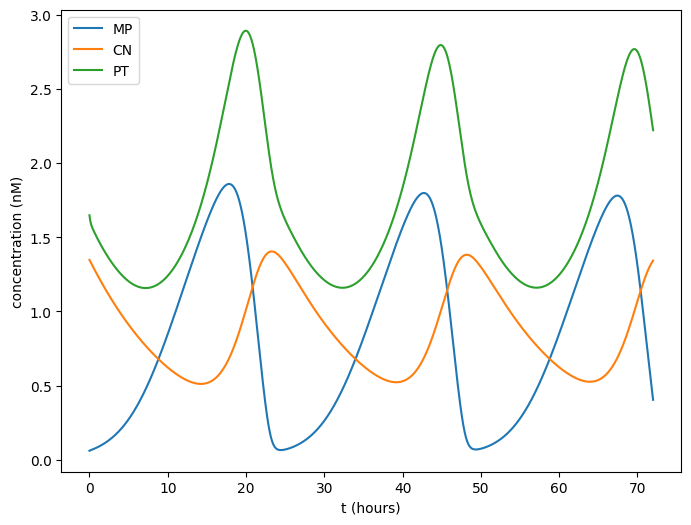

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(t_in_hours, mp, label="MP")
plt.plot(t_in_hours, cn, label="CN")
plt.plot(t_in_hours, pt, label="PT")
plt.legend()
plt.xlabel("t (hours)")
plt.ylabel("concentration (nM)")
plt.savefig("circadian.pdf")
plt.show()